# Demand Forecasting (EDA)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Load Data

Brief Description:
  - salesdate: the day sales happen
  - menuid: menu identification for the menu. (sometimes same menuname not gruanted to have identical menuid)
  - menuname: name of the menu. (FS means flash sales, B1G1 means buy 1 get 1, etc)
  - package:
    - package head: from grab
    - ala carte: no additional attributes
    - package content: has additional attributes 
  - salesNum: each sales identification. for menu sales it will have the same salesNum
  - bomid: identification of bill of material
  - qty_total: total of menu ordered


In [2]:
FOLDER_PATH = '/Users/louisn/Documents/Legit-DS/Selection/demand-forecasting/data/'
DATA_PATH = FOLDER_PATH + 'interview-test.csv'

In [3]:
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   salesdate   8902 non-null   object
 1   menuid      8902 non-null   int64 
 2   menuname    8902 non-null   object
 3   package     8902 non-null   object
 4   salesNum    8902 non-null   int64 
 5   bomid       8902 non-null   int64 
 6   menu_group  8902 non-null   object
 7   qty_total   8902 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 556.5+ KB


In [4]:
df.head(3)

,salesdate,menuid,menuname,package,salesNum,bomid,menu_group,qty_total
0,2022-10-09,518,Premium Beef Deal,Package Content,0,0,0,1
1,2022-10-09,518,Premium Beef Deal,Package Content,1,0,0,1
2,2022-10-09,518,Premium Beef Deal,Package Content,2,0,0,1


In [5]:
df.tail(3)

,salesdate,menuid,menuname,package,salesNum,bomid,menu_group,qty_total
8899,2022-12-02,242,(ALC)Classic Mentega Chicken,Package Head,4995,19,Classic Mentega Chicken,1
8900,2022-12-02,244,(ALC)Kung Pao Chicken,Ala Carte,4996,111,Kung Pao Chicken,1
8901,2022-12-02,245,(ALC)Buttermilk Chicken,Ala Carte,4995,65,Buttermilk Chicken,1


In [6]:
df.nunique()

salesdate      101
menuid         402
menuname       370
package          3
salesNum      5000
bomid          185
menu_group      63
qty_total       14
dtype: int64

In [7]:
# datetime preprocessing
df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')

## Sales Performance (in quantity sold)

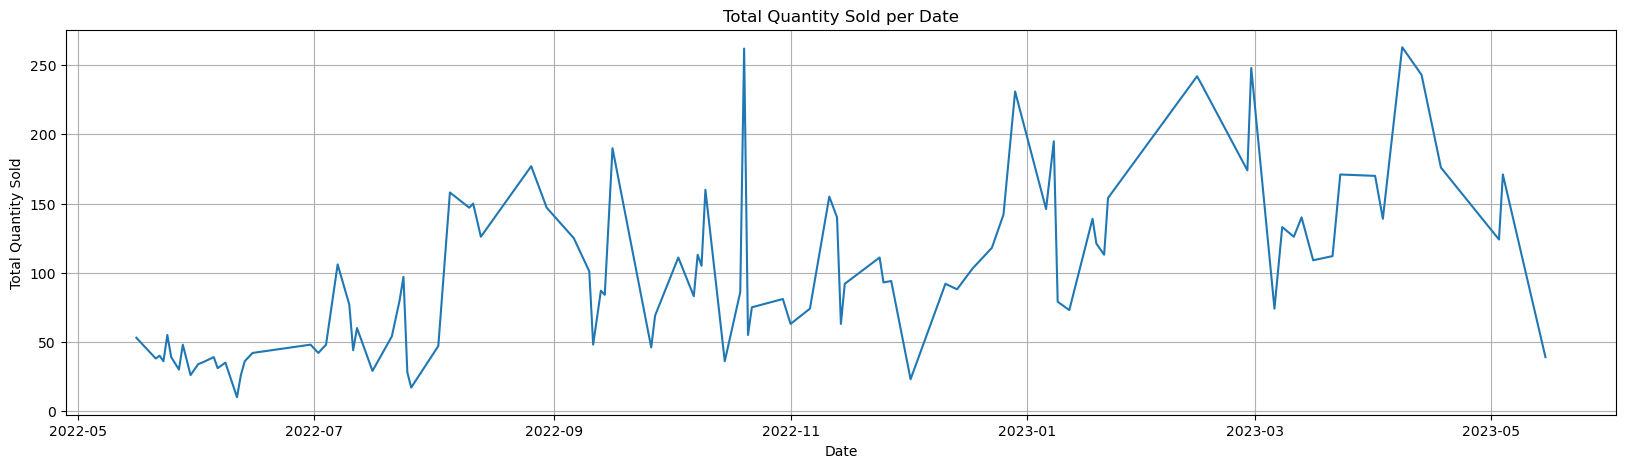

In [8]:
pivot_qty = df.pivot_table(values='qty_total', index='salesdate', aggfunc='sum')

plt.figure(figsize=(20,5))
plt.plot(pivot_qty.index, pivot_qty['qty_total'])
plt.title('Total Quantity Sold per Date')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()

- From the graph below, I couldn't see a clear pattern of monthly seasonality of the sales.
- However there's a slightly uptrend on the quantity sold from over the year
- My hypothesis for now the inclining & declining item sold are affected by FS and B1G1 program

## Seasonality Analysis

In [9]:
decomposition = sm.tsa.seasonal_decompose(pivot_qty['qty_total'].resample('D').sum(), model='additive')

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

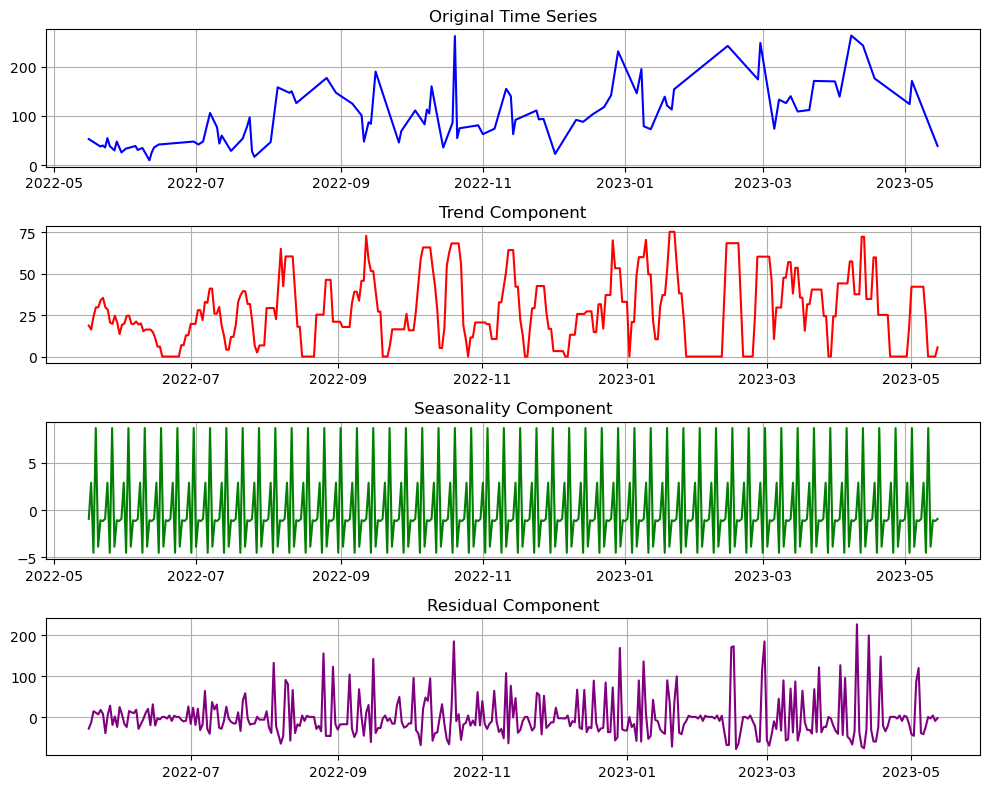

In [10]:
# Plot the components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(pivot_qty['qty_total'], color='blue')
plt.grid(True)
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(trend, color='red')
plt.grid(True)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonality, color='green')
plt.grid(True)
plt.title('Seasonality Component')

plt.subplot(4, 1, 4)
plt.plot(residual, color='purple')
plt.grid(True)
plt.title('Residual Component')

plt.tight_layout()
plt.show()

- Seasonality component that occurs every possibly week

(array([ 35., 118., 126.,  28.,  19.,  15.,   7.,   4.,   5.,   2.]),
 array([-77.13379967, -46.77012805, -16.40645643,  13.95721519,
         44.32088682,  74.68455844, 105.04823006, 135.41190168,
        165.77557331, 196.13924493, 226.50291655]),
 <BarContainer object of 10 artists>)

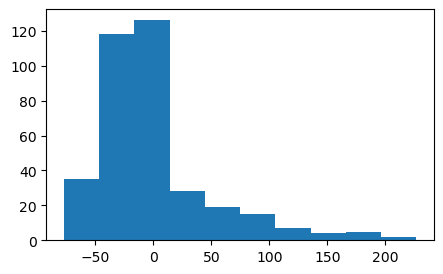

In [11]:
plt.figure(figsize=(5,3))
plt.hist(residual)

## Weekly Performance

In [12]:
df_copy = df.copy()
df_copy.set_index('salesdate', inplace=True)

weekly_data = df_copy.resample('W').sum()
# weekly_data.head()

df_copy['weekday'] = df_copy.index.weekday


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_43467/3950457135.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_data = df_copy.resample('W').sum()


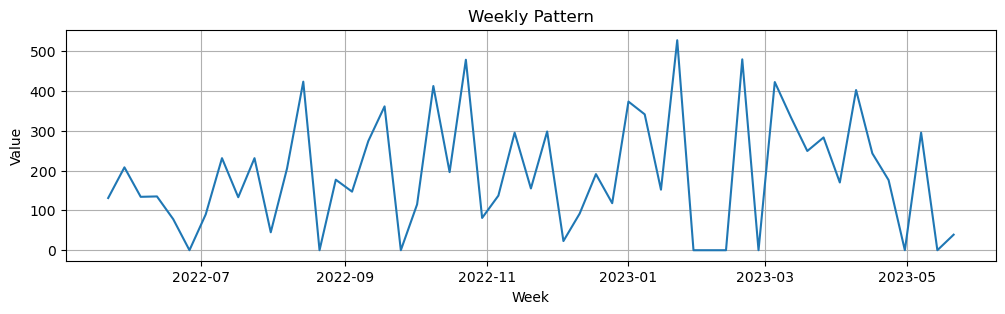

In [13]:
plt.figure(figsize=(12, 3))
plt.plot(weekly_data.index, weekly_data['qty_total'])
plt.xlabel('Week')
plt.ylabel('Value')
plt.title('Weekly Pattern')
plt.grid(True)
plt.show()

<Figure size 1200x500 with 0 Axes>

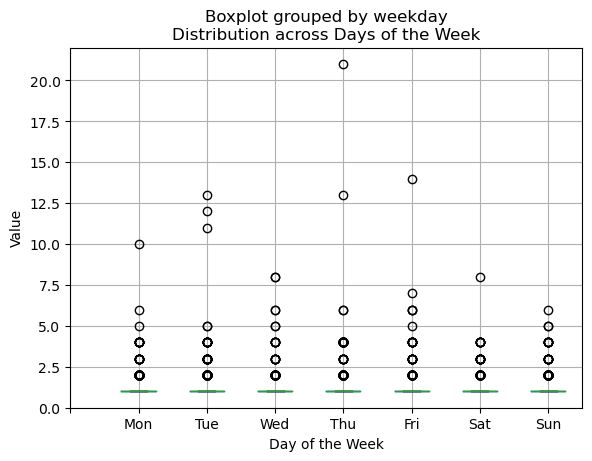

In [14]:
plt.figure(figsize=(12, 5))
df_copy.boxplot(column='qty_total', by='weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Value')
plt.title('Distribution across Days of the Week')
plt.xticks(range(8), ['','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

- In the boxplot, we observe that there's till many outliers that falls outside the whiskers, indicating a data point that significantly deviates from the rest of the values.
- the high residuals suggest that our forecasting model may have difficulty accurately predicting certain data points

## Promos (FS and B1G1)

In [15]:
df_promo = df.copy()
df_promo.set_index('salesdate', inplace=True)
df_promo.drop(columns=['bomid', 'salesNum'], axis=1, inplace=True)

In [16]:
df_promo.head()

,menuid,menuname,package,menu_group,qty_total
salesdate,,,,,
2022-10-09,518,Premium Beef Deal,Package Content,0,1
2022-10-09,518,Premium Beef Deal,Package Content,0,1
2022-10-09,518,Premium Beef Deal,Package Content,0,1
2022-10-09,519,[FS] Spaghetti Prawn/Chicken Aglio Olio,Package Head,Spaghetti Prawn/Chicken Aglio Olio,1
2022-10-09,519,[FS] Spaghetti Prawn/Chicken Aglio Olio,Package Head,Spaghetti Prawn/Chicken Aglio Olio,1


In [17]:
menunames = df_promo['menuname'].unique()

print(f"found: {len(menunames)} menunames")

found: 370 menunames


In [18]:
# extract pattern for Flash Sale
pattern = r'\[(.*?)\]'
df_promo['FS'] = df_promo['menuname'].str.contains(pattern)

# extract pattern B1G1
pattern = r'(B1G1)'
df_promo['B1G1'] = df_promo['menuname'].str.contains(pattern)
# df_promo.head()

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_43467/2170396546.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_promo['FS'] = df_promo['menuname'].str.contains(pattern)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_43467/2170396546.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_promo['B1G1'] = df_promo['menuname'].str.contains(pattern)


In [19]:
df_new = df_promo.drop(columns=['menuname', 'package', 'menu_group','menuid'], axis=1)
df_new.head()

,qty_total,FS,B1G1
salesdate,,,
2022-10-09,1,False,False
2022-10-09,1,False,False
2022-10-09,1,False,False
2022-10-09,1,True,False
2022-10-09,1,True,False


now we want to aggregate how much FS and B1G1 promo is used each day

In [20]:
df_agg_fs = df_new[df_new['FS']]
df_agg_b1g1 = df_new[df_new['B1G1']]

In [21]:
df_agg1 = pd.pivot_table(df_agg_fs, 
                        index=df_agg_fs.index, 
                        values='qty_total', 
                        aggfunc='sum', 
                        fill_value=0)

df_agg2 = pd.pivot_table(df_agg_b1g1, 
                        index=df_agg_b1g1.index, 
                        values='qty_total', 
                        aggfunc='sum', 
                        fill_value=0)

df_agg1.head()
df_agg2.head()

,qty_total
salesdate,
2023-02-14,64
2023-02-15,67
2023-02-27,37
2023-02-28,79
2023-03-06,4


In [22]:
# merge both pivot table
df_agg = pd.merge(
    df_agg1,
    df_agg2,
    how='outer',
    left_index=True,
    right_index=True
)
df_agg.rename(columns= {
    'qty_total_x': 'FS_total',
    'qty_total_y': 'B1G1_total'
}, inplace=True)

# fillNa with 0
df_agg.fillna(0, inplace=True)

df_agg.head()

,FS_total,B1G1_total
salesdate,,
2022-06-08,2.0,0.0
2022-06-13,2.0,0.0
2022-06-15,3.0,0.0
2022-08-02,1.0,0.0
2022-08-05,8.0,0.0


In [23]:
# Merge df_agg with qty_total in pivot_qty
df_corr = pd.merge(
    df_agg,
    pivot_qty,
    how='outer',
    left_index=True,
    right_index=True
)
df_corr.fillna(0, inplace=True)
df_corr.sample(5)

,FS_total,B1G1_total,qty_total
salesdate,,,
2022-11-01,23.0,0.0,63
2022-10-22,3.0,0.0,75
2022-10-19,8.0,0.0,86
2022-07-07,0.0,0.0,106
2022-12-18,0.0,0.0,103


now we want to like to create weekday and month features

In [29]:
# feature engineer weekday and month, there is no year feature because the data only consisted for 1 year
df_corr_dt = df_corr.copy()
df_corr_dt['weekday'] = df_corr_dt.index.weekday
df_corr_dt['week'] = (df_corr_dt.index.day - 1) // 7 + 1
df_corr_dt['month'] = df_corr_dt.index.month

# dummy encoding the weekday & month features
df_corr_dt_enc = pd.get_dummies(df_corr_dt, columns=['weekday', 'month','week'])

df_corr_dt_enc.head(1)


,FS_total,B1G1_total,qty_total,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,...,month_8,month_9,month_10,month_11,month_12,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,,,,,,,,,,,,,,
2022-05-16,0.0,0.0,53,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


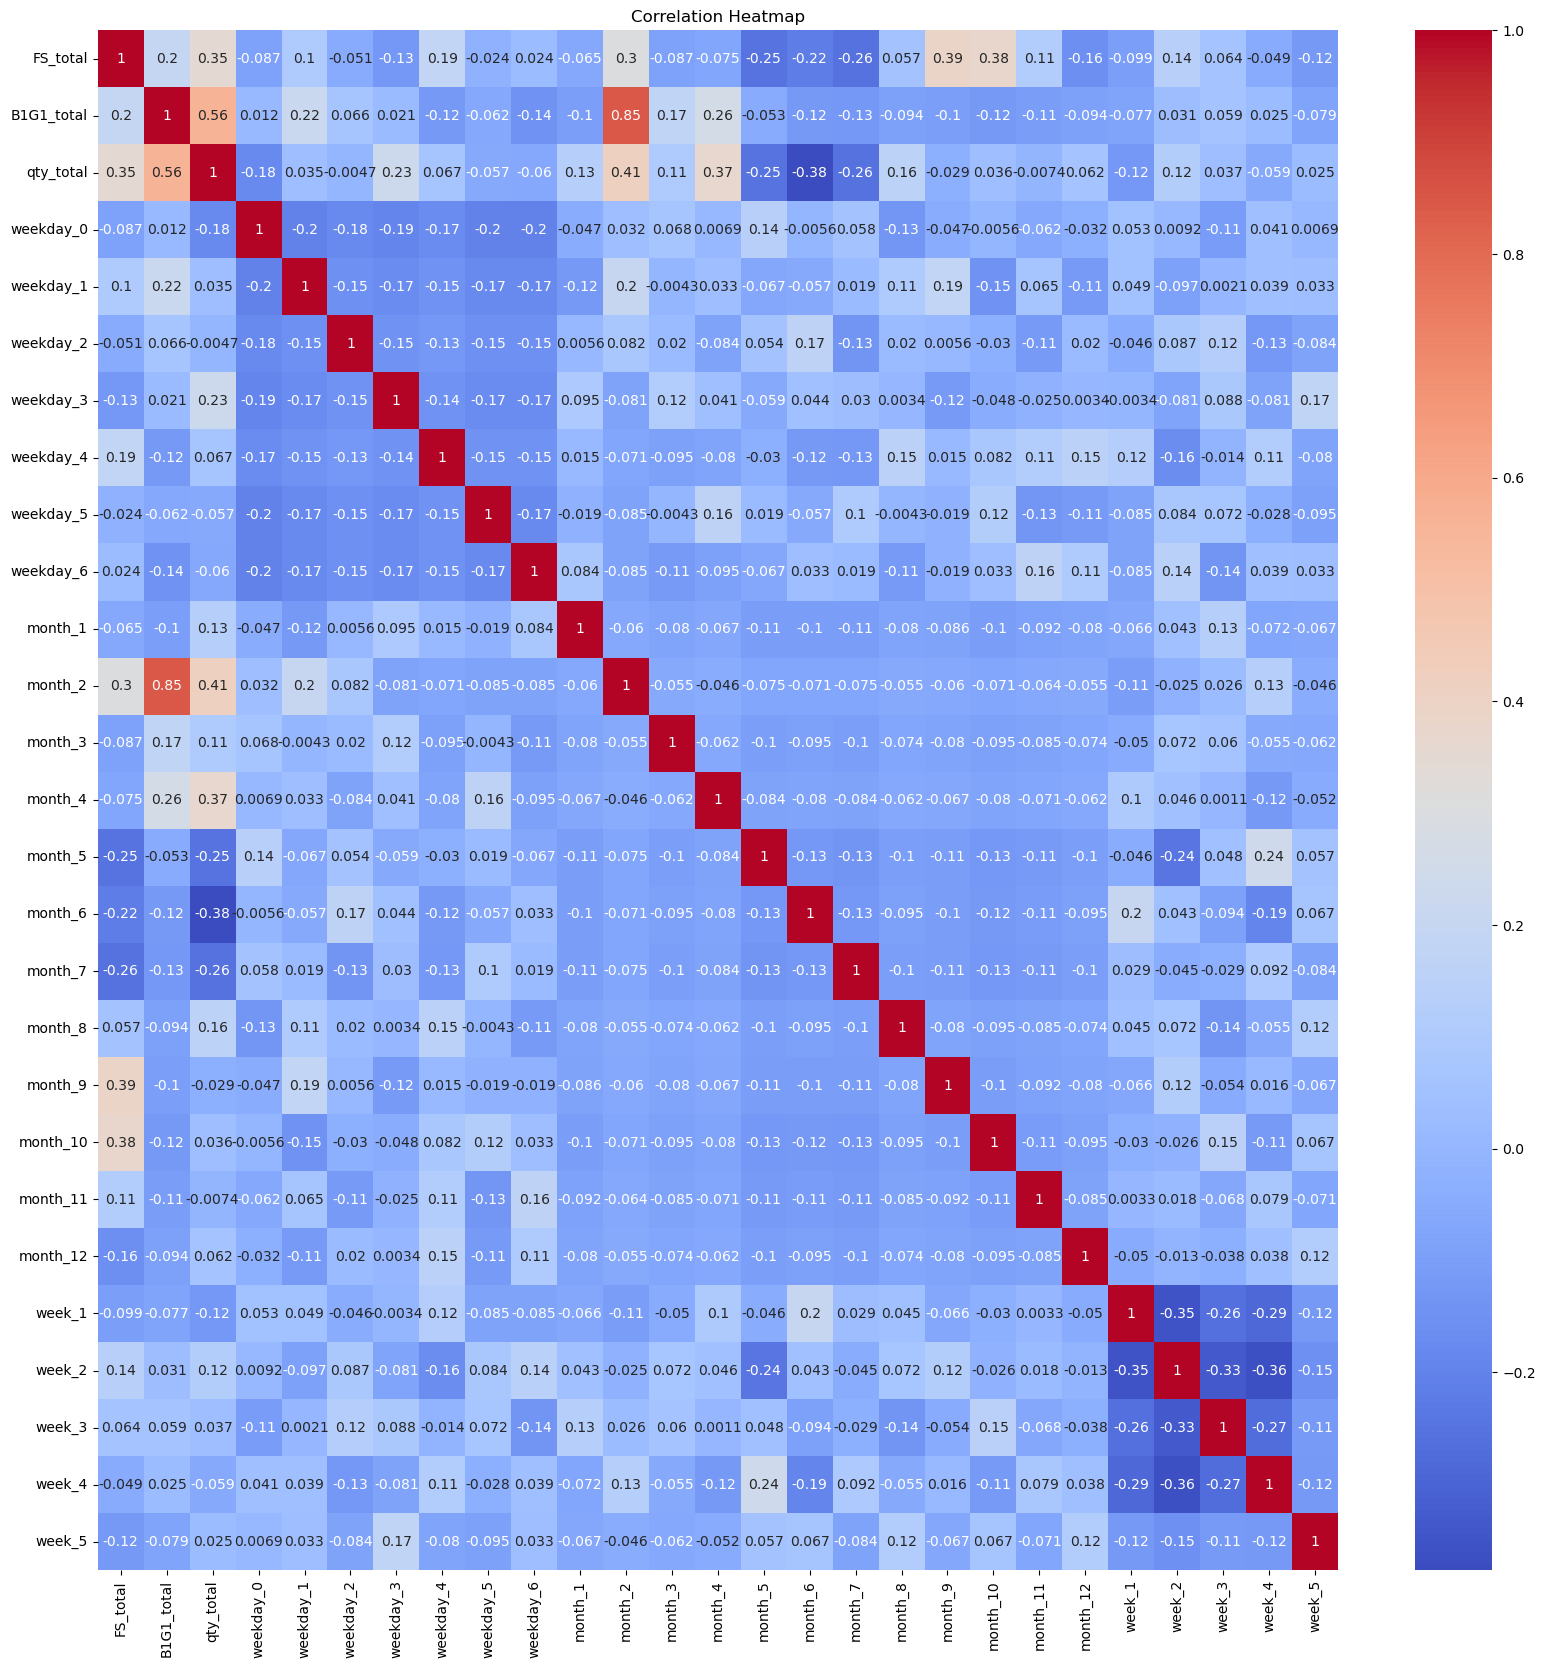

In [33]:
corr_matrix = df_corr_dt_enc.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

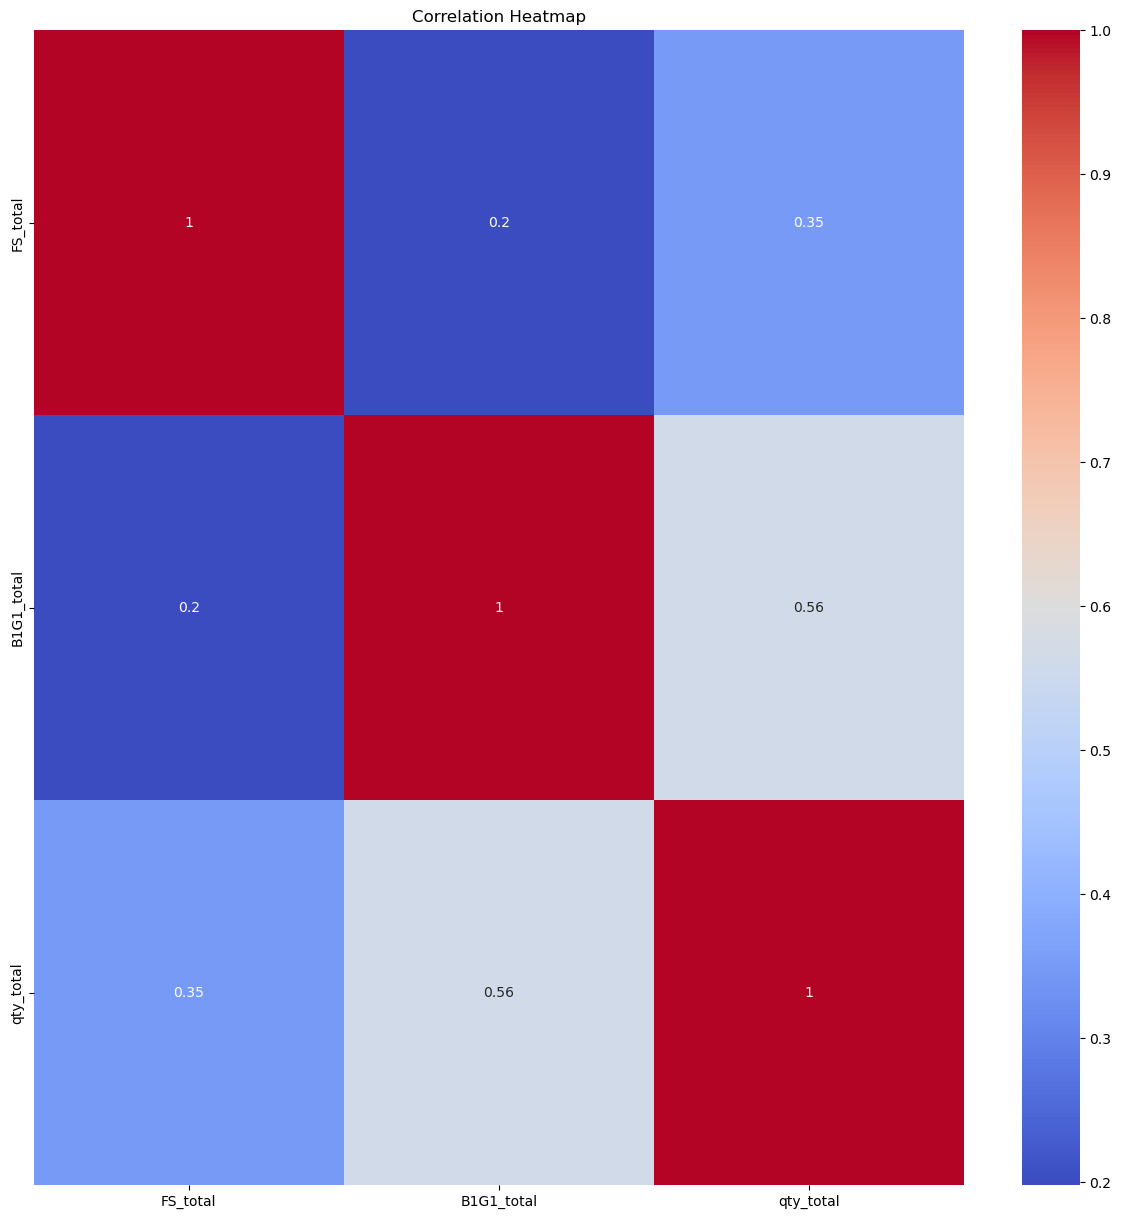

In [32]:
corr_matrix = df_corr.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- From the heatmap correlation above, there's a moderate positive correlation between B1G1_total, and slightly lower moderate positive correlation between FS_total to qty_total
- There are also moderate positive correlation between in month2 that can be explained by the strong positive correlation of month2 with B1G1_total that suggest there are big B1G1 promos in month2
- However there are no or weak correlation between weekdays, weeks with the qty_total.
- the hypothesis of B1G1 & FS Promos are more correlated with the sales in qty_total rather than weekly or monthly condition.

## Menu Grouping

Perormed grouping using fuzzywuzzy algorithm. [on hold for now]

## Modeling 

the objective of the model is to forecast the amount of qty_total for every item that should be available for the next week.


input:
- date: datetime --> predict on date
- B1G1: Bool --> Will there be a B1G1 promo?
- FS: Bool --> Will there be a FS promo
- menu: menu group name --> predicted menu

output:
- qty_1w: amount of qty should be availble for that week